In [63]:
# imports and setup
import os
from pathlib import Path
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
plt.style.use('seaborn-v0_8')
os.makedirs('figures', exist_ok=True)
os.makedirs('data', exist_ok=True)
%matplotlib inline

In [ ]:
# Constants 
SENTIMENT = 'review_score'
NEGATIVE_SENTIMENT = '#e15759'
POSITIVE_SENTIMENT = '#4e79a7'
TARGET_PALLETTE = {-1: NEGATIVE_SENTIMENT, 1: POSITIVE_SENTIMENT }

### 1 - Data Acquisition: Import the Dataset from Kaggle
- Dataset (Kaggle): [steam-reviews](https://www.kaggle.com/datasets/andrewmvd/steam-reviews/data)

- Dataset (local): [data/dataset.csv](data/dataset.csv)


In [73]:
# Optional - Dataset included under data directory
# path = kagglehub.dataset_download("andrewmvd/steam-reviews")

In [ ]:
# Optional 
# path

'C:\\Users\\Fatema\\.cache\\kagglehub\\datasets\\andrewmvd\\steam-reviews\\versions\\3'

In [ ]:
# Optional: 
# On windows terminal use
# ! copy $path\dataset.csv data\

# on unix terminal use
# ! cp $path\dataset.csv data\


        1 file(s) copied.


In [ ]:
df = pd.read_csv('data/dataset.csv')

In [6]:
df.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   app_id        int64 
 1   app_name      object
 2   review_text   object
 3   review_score  int64 
 4   review_votes  int64 
dtypes: int64(3), object(2)
memory usage: 244.8+ MB


In [8]:
df.describe()

,app_id,review_score,review_votes
count,6.417106e+06,6.417106e+06,6.417106e+06
mean,2.274695e+05,6.394992e-01,1.472446e-01
std,1.260451e+05,7.687918e-01,3.543496e-01
min,1.000000e+01,-1.000000e+00,0.000000e+00
25%,2.018100e+05,1.000000e+00,0.000000e+00
50%,2.391600e+05,1.000000e+00,0.000000e+00
75%,3.056200e+05,1.000000e+00,0.000000e+00
max,5.653400e+05,1.000000e+00,1.000000e+00


### 2- EDA

In [18]:
print('Number of games reviewed: {}'.format(df['app_id'].nunique())) # how many games are there?

Number of games reviewed: 9972


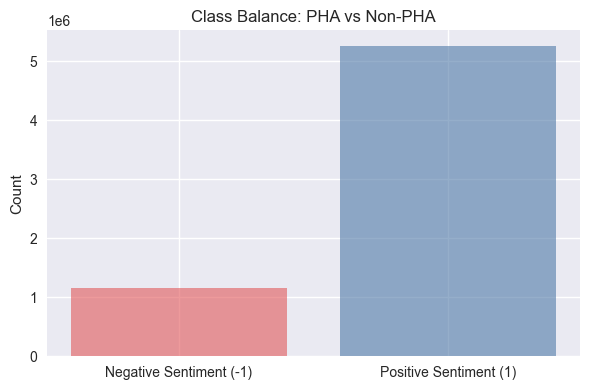

In [65]:
fig, ax = plt.subplots(figsize=(6,4))
counts = df[SENTIMENT].value_counts().sort_index()
ax.bar(x=['Negative Sentiment (-1)', 'Positive Sentiment (1)'],height=counts.values, color=[NEGATIVE_SENTIMENT,POSITIVE_SENTIMENT], alpha=0.6)
ax.set_title('Class Balance: PHA vs Non-PHA')
ax.set_ylabel('Count')
fig.tight_layout()
plt.savefig('figures/sentiment_class_balance.png')

In [ ]:
# 

In [52]:
def make_balanced_subset(
    csv_path: str = "data/dataset.csv",
    score_col: str = "review_score",
    classes: tuple = (-1, 1),
    total_target: int = 500_000,
    random_state: int = 42,
    save_path: str = "data/new_dataset",
    save_format: str = "csv",
    oversample_if_needed: bool = True
) -> pd.DataFrame:
    """
    Create a balanced subset of size `total_target` across `classes`.
    If any class has < target_per_class, optionally oversample with replacement.

    Returns the balanced DataFrame. Optionally saves to Parquet/CSV.
    """
    assert total_target % len(classes) == 0, "total_target must be divisible by number of classes."
    target_per_class = total_target // len(classes)

    # 1) Load
    df = pd.read_csv(csv_path)

    # 2) Keep only the desired classes (robust to stray values)
    df = df[df[score_col].isin(classes)].copy()

    # 3) Count per class
    counts = df[score_col].value_counts().reindex(classes).fillna(0).astype(int)
    print("Class counts before balancing:", counts.to_dict())

    # 4) For each class: sample appropriately
    parts = []
    for c in classes:
        df_c = df[df[score_col] == c]

        if len(df_c) >= target_per_class:
            # Downsample without replacement
            part = df_c.sample(n=target_per_class, replace=False, random_state=random_state)
        else:
            if oversample_if_needed:
                # Sample with replacement to reach target
                part = df_c.sample(n=target_per_class, replace=True, random_state=random_state)
                print(f"Warning: Class {c} had only {len(df_c)} rows; oversampling with replacement to {target_per_class}.")
            else:
                # Take what we have (no replacement), and total will be smaller than requested
                part = df_c.sample(n=len(df_c), replace=False, random_state=random_state)
                print(f"Notice: Class {c} limited to {len(df_c)} rows (no oversampling).")

        parts.append(part)

    # 5) Concatenate, shuffle, reset index
    balanced = pd.concat(parts, axis=0)
    balanced = balanced.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

    # 6) Verify
    final_counts = balanced[score_col].value_counts().reindex(classes).fillna(0).astype(int)
    print("Class counts after balancing:", final_counts.to_dict())
    print("Final size:", len(balanced))

    # 7) Optional save
    if save_path:
        if save_format.lower() == "parquet":
            balanced.to_parquet(save_path, index=False)
        elif save_format.lower() == "csv":
            balanced.to_csv(save_path, index=False)
        else:
            raise ValueError("save_format must be 'parquet' or 'csv'.")
        print(f"Saved to {save_path}")

    return balanced

balanced_path = 'data/dataset_balanced_500k.csv'
balanced_file = Path(balanced_path)

balanced_df = (pd.read_csv(balanced_path) if balanced_file.exists() else make_balanced_subset(
    csv_path="data/dataset.csv",
    score_col="review_score",
    classes=(-1, 1),
    total_target=500_000,
    random_state=42,
    save_path=balanced_path,
    save_format='csv',
    oversample_if_needed=True,
))

In [53]:
balanced_df.head()

,app_id,app_name,review_text,review_score,review_votes
0,221100,DayZ,Early Access Review,-1,0
1,221100,DayZ,Early Access Review,-1,0
2,230230,Divinity: Original Sin (Classic),Update: After finally mustering up the attent...,-1,1
3,292500,Kero Blaster,Darn I hate to be the only person to give it a...,-1,1
4,212680,FTL: Faster Than Light,Hours played / Money spent = Bargain,1,0


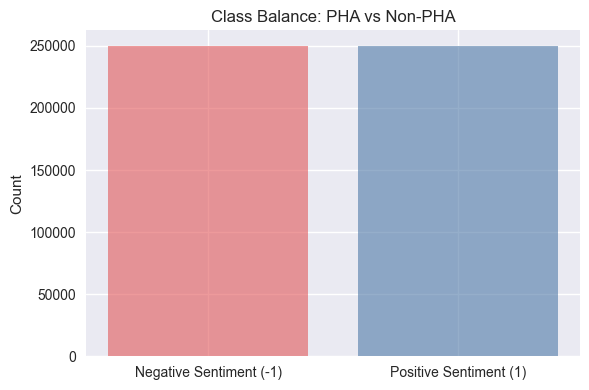

In [64]:
fig, ax = plt.subplots(figsize=(6,4))
counts = balanced_df[SENTIMENT].value_counts().sort_index()
ax.bar(x=['Negative Sentiment (-1)', 'Positive Sentiment (1)'],height=counts.values, color=[NEGATIVE_SENTIMENT,POSITIVE_SENTIMENT], alpha=0.6)
ax.set_title('Class Balance: PHA vs Non-PHA')
ax.set_ylabel('Count')
fig.tight_layout()
plt.savefig('figures/sentiment_class_balance_balanced_df.png')

In [67]:
def showWordcloud(df, saveTo): 
    txt = ' '.join(rev for rev in df.review_text.astype('str'))
    plt.figure(figsize=(15,8))

    wordcloud = WordCloud(
                background_color = 'black',
                max_font_size = 100,
                max_words = 100,
                width = 1000,
                height = 600
                ).generate(txt)


    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis('off')
    plt.savefig(saveTo)
    plt.show()

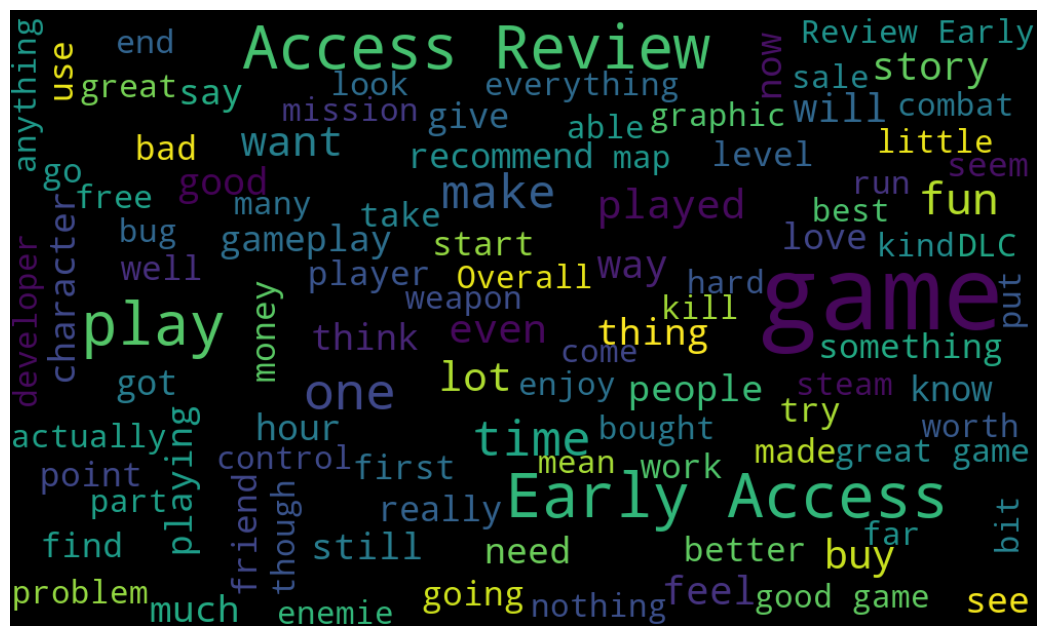

In [68]:
# Wordcloud for review_text
showWordcloud(balanced_df,'figures/wordcloud.png')

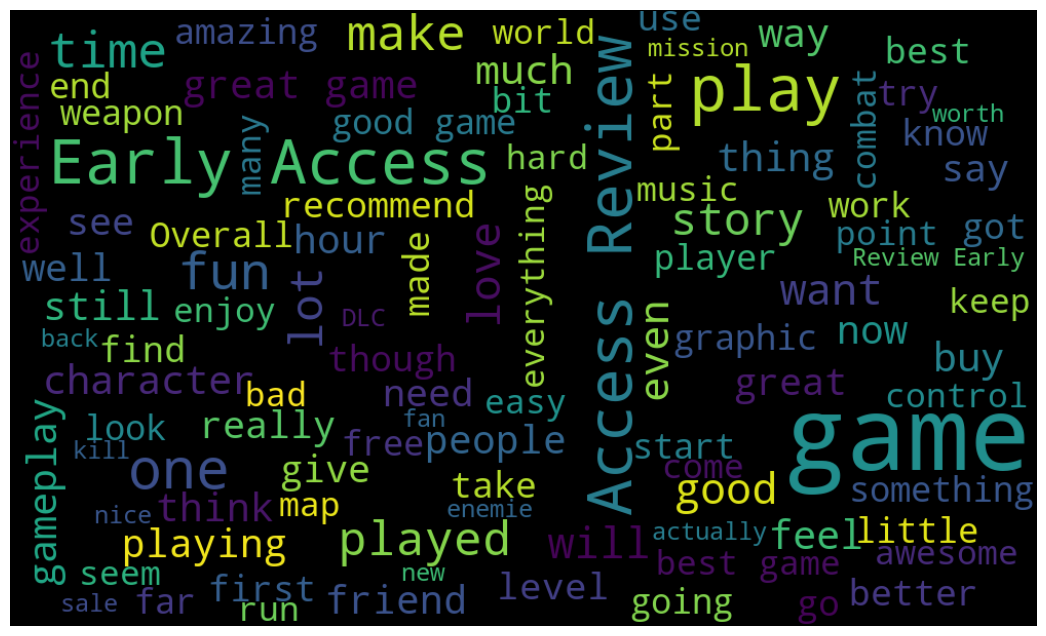

In [70]:
# Wordcloud for positive sentiment
showWordcloud(balanced_df[balanced_df['review_score'] == 1],'figures/wordcloud_positive.png')

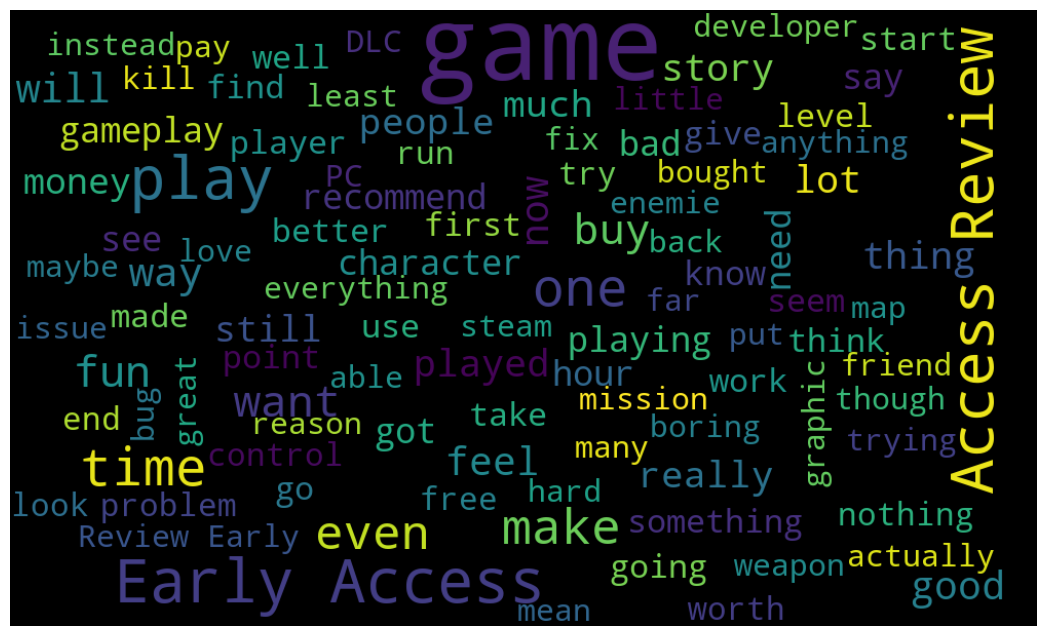

In [71]:
# Wordcloud for negative sentiment
showWordcloud(balanced_df[balanced_df['review_score'] == -1],'figures/wordcloud_negative.png')

In [103]:
# Dominating Words for both Categories: Does not provide information about sentiment 
# Access Review 
# To validate will check how many with Access Review are there in each sentiment
print(balanced_df['review_text'].unique()) # First Appearance ' Early Access Review'
print('\n Total Count of " Early Access Review" = {}'.format(balanced_df[balanced_df['review_text'] ==  ' Early Access Review']['review_text'].count()))
print('\nCount of " Early Access Review" per sentiment\n')
balanced_df[balanced_df['review_text'].eq(' Early Access Review')].groupby('review_score').count()
# will drop these records as they are not likely to provide any information about the sentiment of the text

[' Early Access Review'
 "Update:  After finally mustering up the attention span to finish the game, I'd have to say that the last half of the game is extremely underwhelming. There's no satisfying loot. The story ends up becoming a masturbatory tosser by the end. The tactical feel looses its edge as the developers get lazy with balancing and combat scenarios, with the game distilling down to 'tried and true' by character level 10 since the game's enemies never really get more varied or intelligent.  I think the most disappointing part of the game was the last stretch through the Phantom Forest. The story basically is grasping at what uninteresting and forced story elements it's shoved in your face for the last 40 hours of slowly from objective to objective. The 'nature' of the two main characters isn't some sort of revelation at the end, they flaunt it particularly often and it's extremely bothersome at this last third or so of the game. On top of it: the last boss fight is a ♥♥♥♥ing 

,app_id,app_name,review_text,review_votes
review_score,,,,
-1,45796,43413,45796,45796
1,38060,36938,38060,38060


In [105]:
balanced_df = balanced_df[balanced_df['review_text'] != ' Early Access Review']
balanced_df.count()

app_id          416144
app_name        402007
review_text     415607
review_score    416144
review_votes    416144
dtype: int64

In [108]:
# visualize number of words per review:
balanced_df['review_word_count'] = balanced_df['review_text'].apply(lambda sentence: len(str(sentence).split()))
balanced_df.head()

,app_id,app_name,review_text,review_score,review_votes,review_word_count
2,230230,Divinity: Original Sin (Classic),Update: After finally mustering up the attent...,-1,1,1266
3,292500,Kero Blaster,Darn I hate to be the only person to give it a...,-1,1,89
4,212680,FTL: Faster Than Light,Hours played / Money spent = Bargain,1,0,7
5,111900,Guardians of Middle-earth,worst pile of laggy junk ever made,-1,0,7
6,24200,DC Universe Online,daybreak games = dey break games disconnects a...,-1,0,48


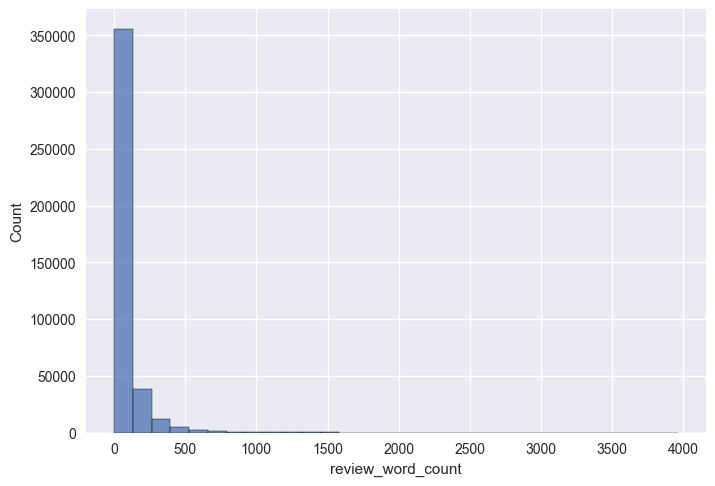

In [ ]:
sns.histplot(data=balanced_df, x="review_word_count",bins=30)
plt.savefig("figures/word_count_barchart.png")
# most words are between 0-250 words approx

In [ ]:
# Find the most common 20 words
words = (
    balanced_df['review_text']
    .astype(str)
    .str.lower()        
    .str.split()        
    .explode()          
)

# Get top 20 words
top_words = words.value_counts().head(20).reset_index()
top_words.columns = ['Common Words', 'count']

# Display with gradient
top_words.style.background_gradient(cmap='Reds')

,Common Words,count
0,the,1384820
1,and,796426
2,to,788295
3,a,764839
4,i,604664
5,of,560033
6,is,523822
7,game,504424
8,you,490455
9,this,444769


### 3- Data Preprocessing

In [128]:
# Clean null values
balanced_df.isnull().sum()


app_id                   0
app_name             14137
review_text            537
review_score             0
review_votes             0
review_word_count        0
dtype: int64

In [ ]:
# app_name nulls can be ignored as the model will not use it for sentiment analysis, however 537 records with null review_text will be dropped
balanced_df = balanced_df.dropna(subset=['review_text'])
balanced_df.isnull().sum()

app_id                   0
app_name             14129
review_text              0
review_score             0
review_votes             0
review_word_count        0
dtype: int64

In [ ]:
# Remove duplicate values keeping only one occurrence 
balanced_df = balanced_df.drop_duplicates(keep='first')
balanced_df.count()

app_id               407539
app_name             393611
review_text          407539
review_score         407539
review_votes         407539
review_word_count    407539
dtype: int64

### 4- Model Training

### 5- Results Evaluations